# Test DRDV Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Sensor_noise


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


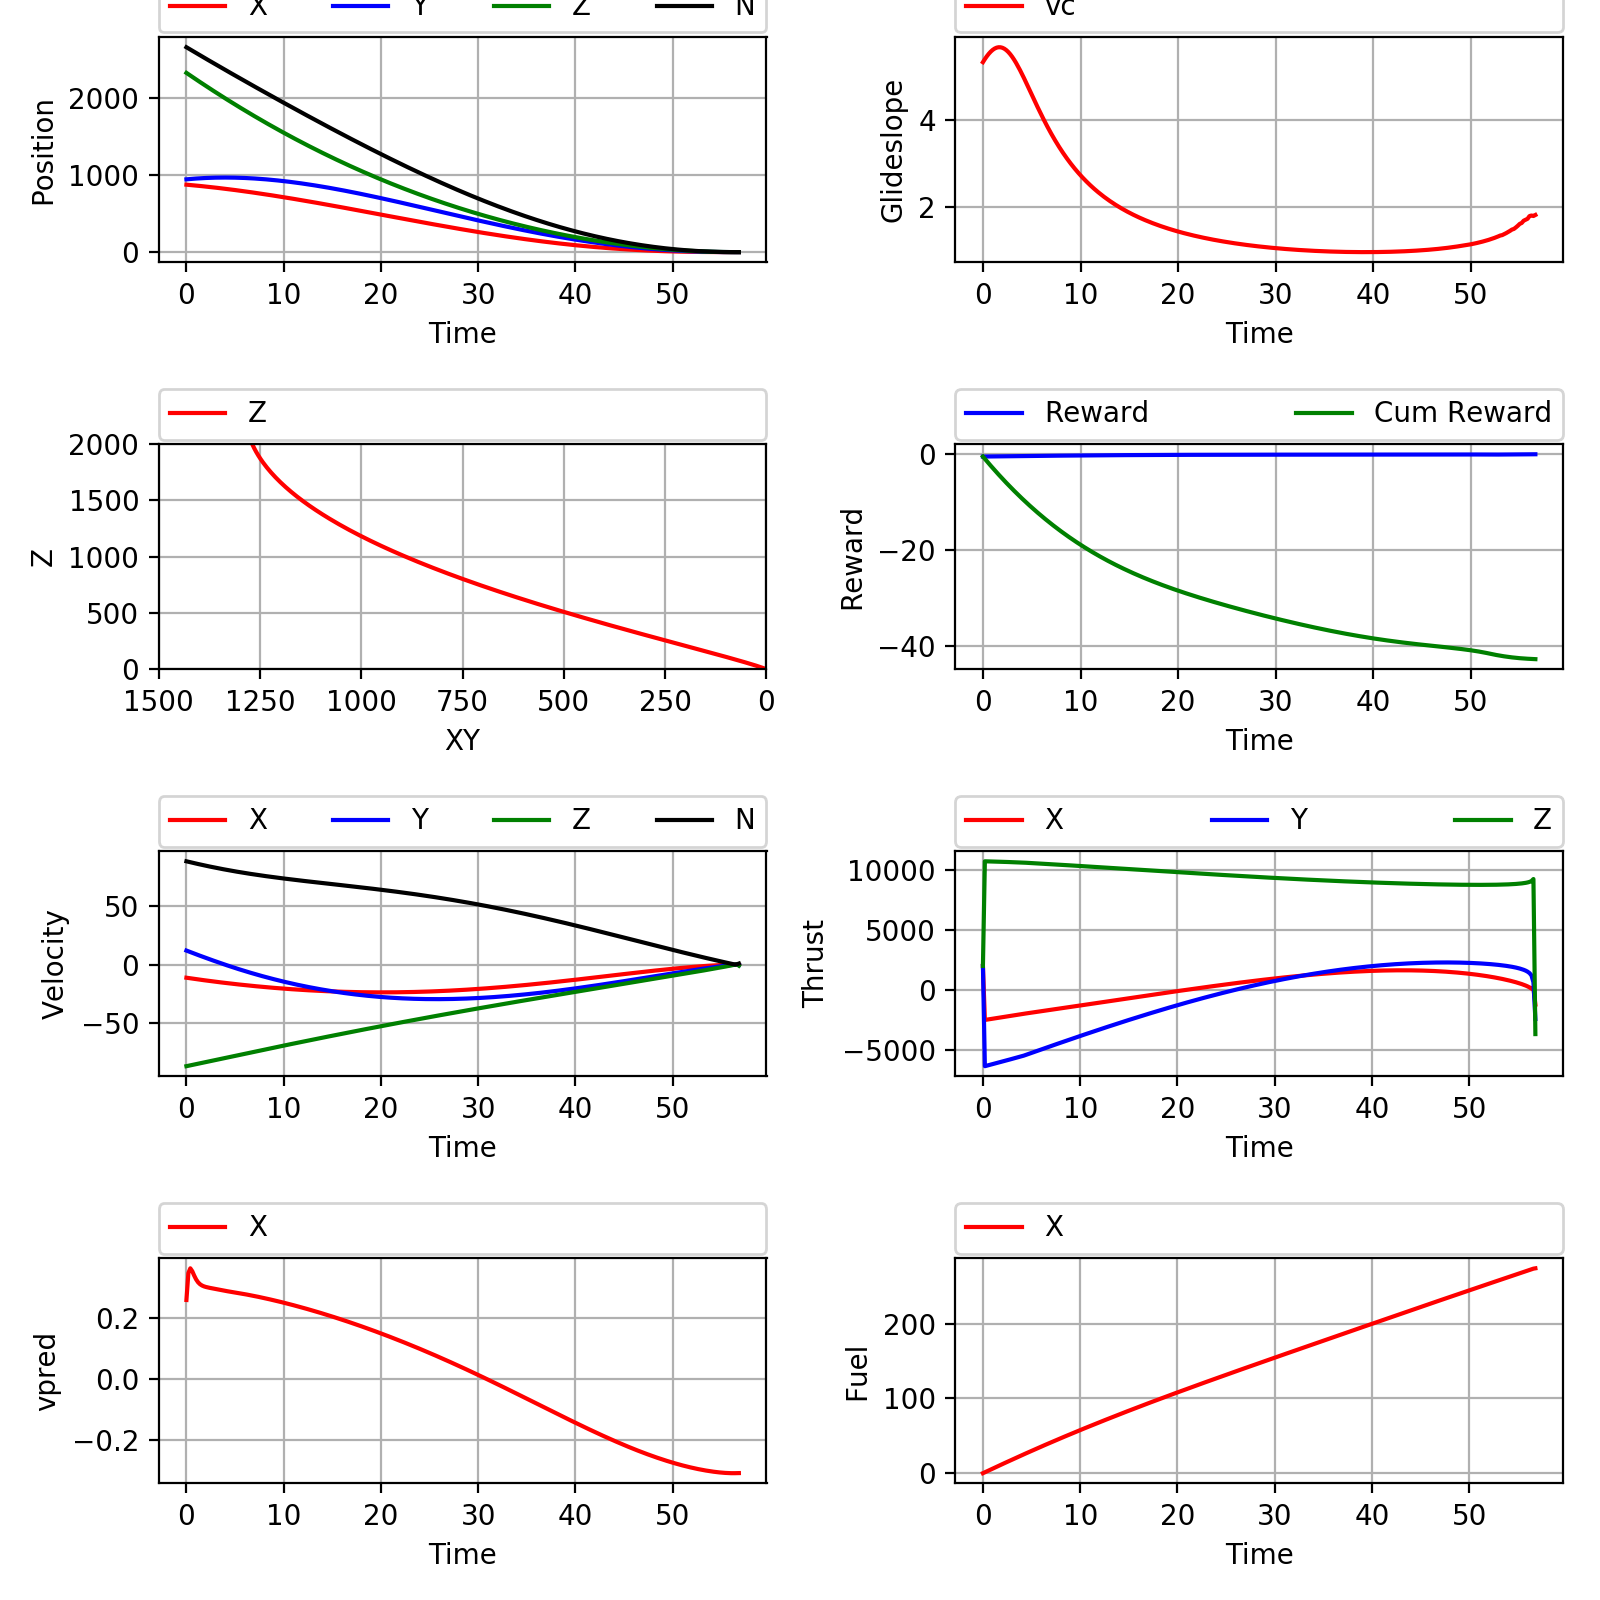

<IPython.core.display.Javascript object>


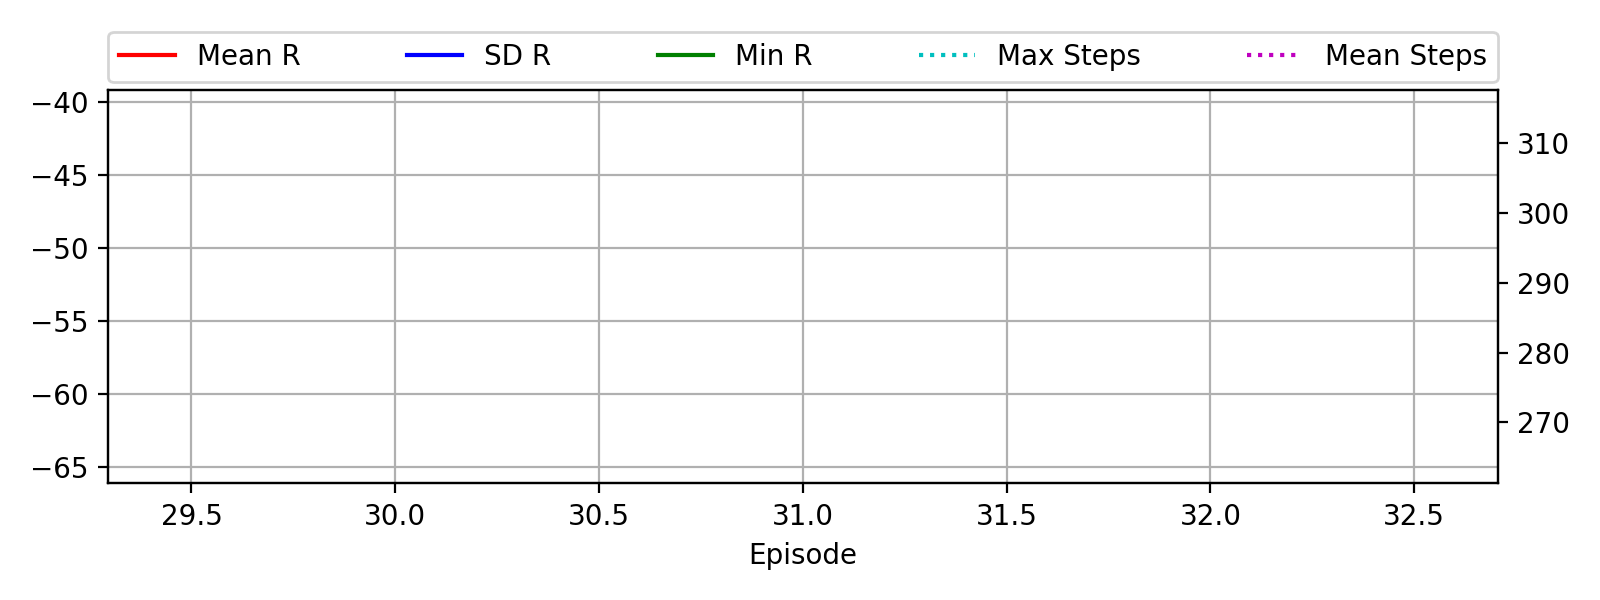

<IPython.core.display.Javascript object>


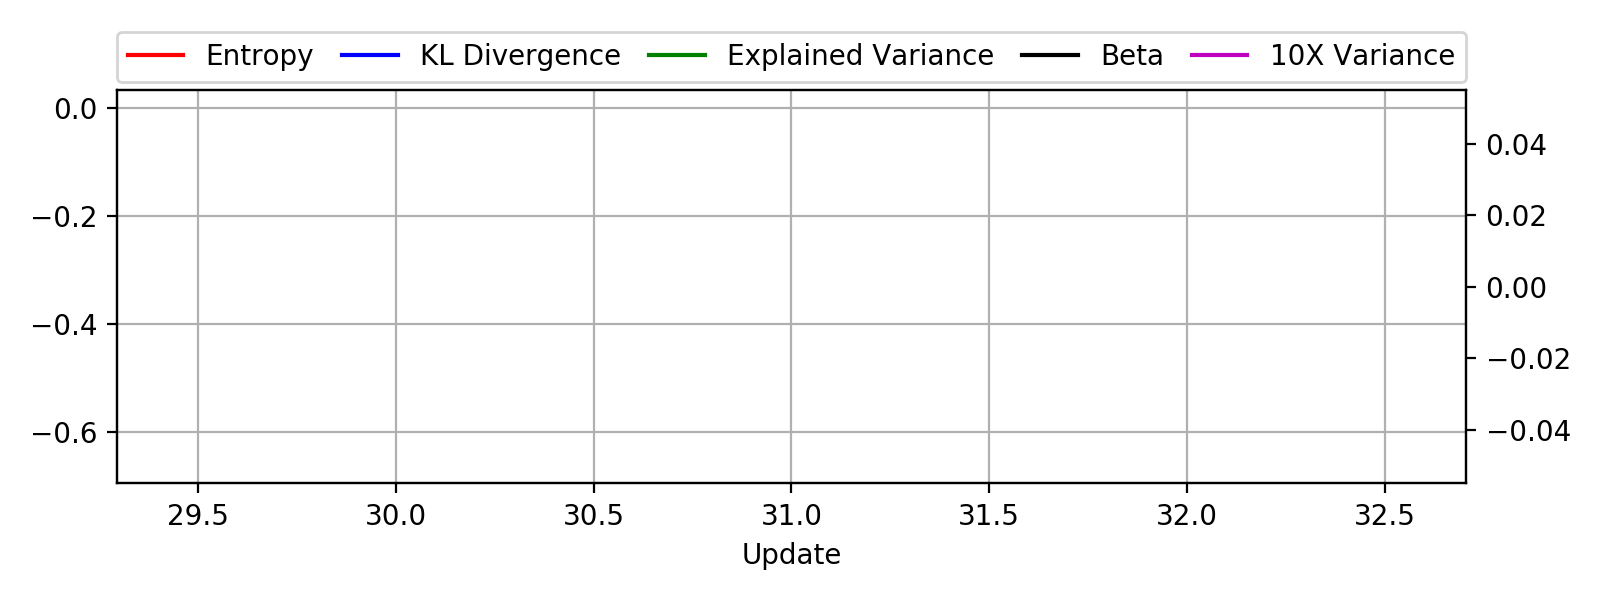

<IPython.core.display.Javascript object>


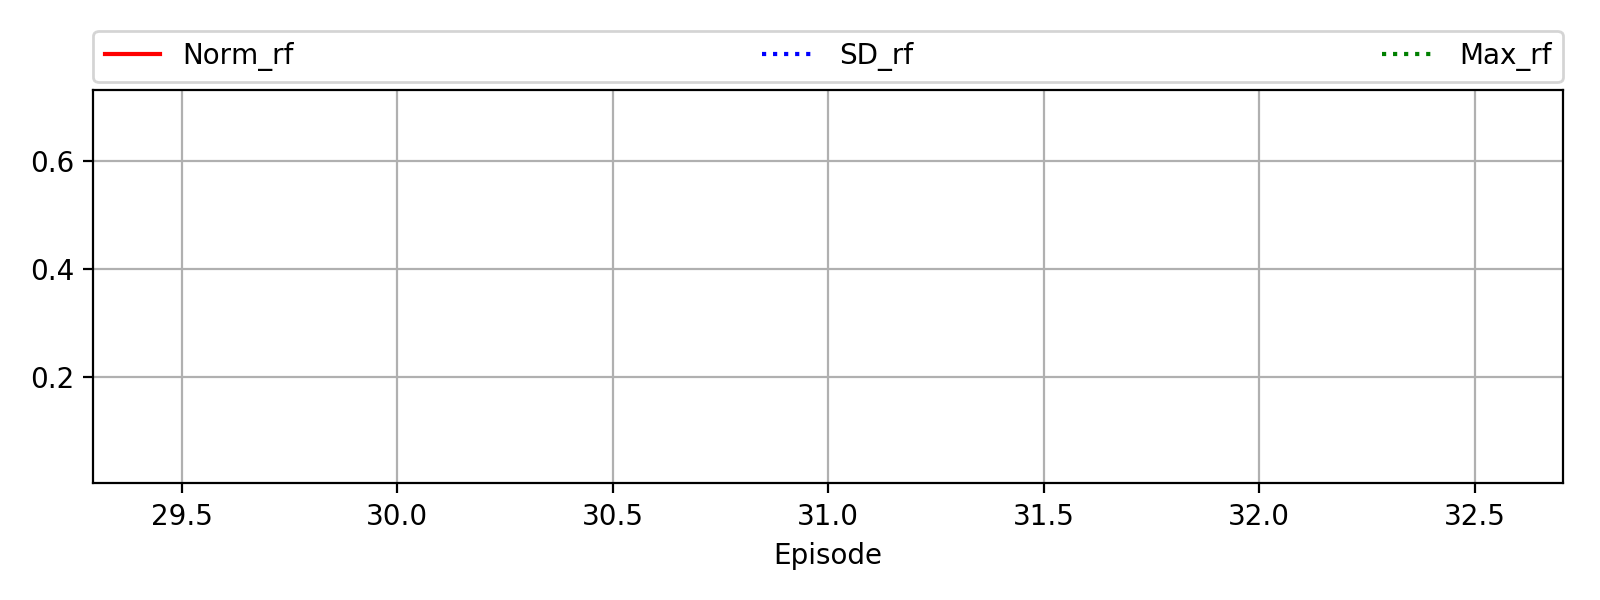

<IPython.core.display.Javascript object>


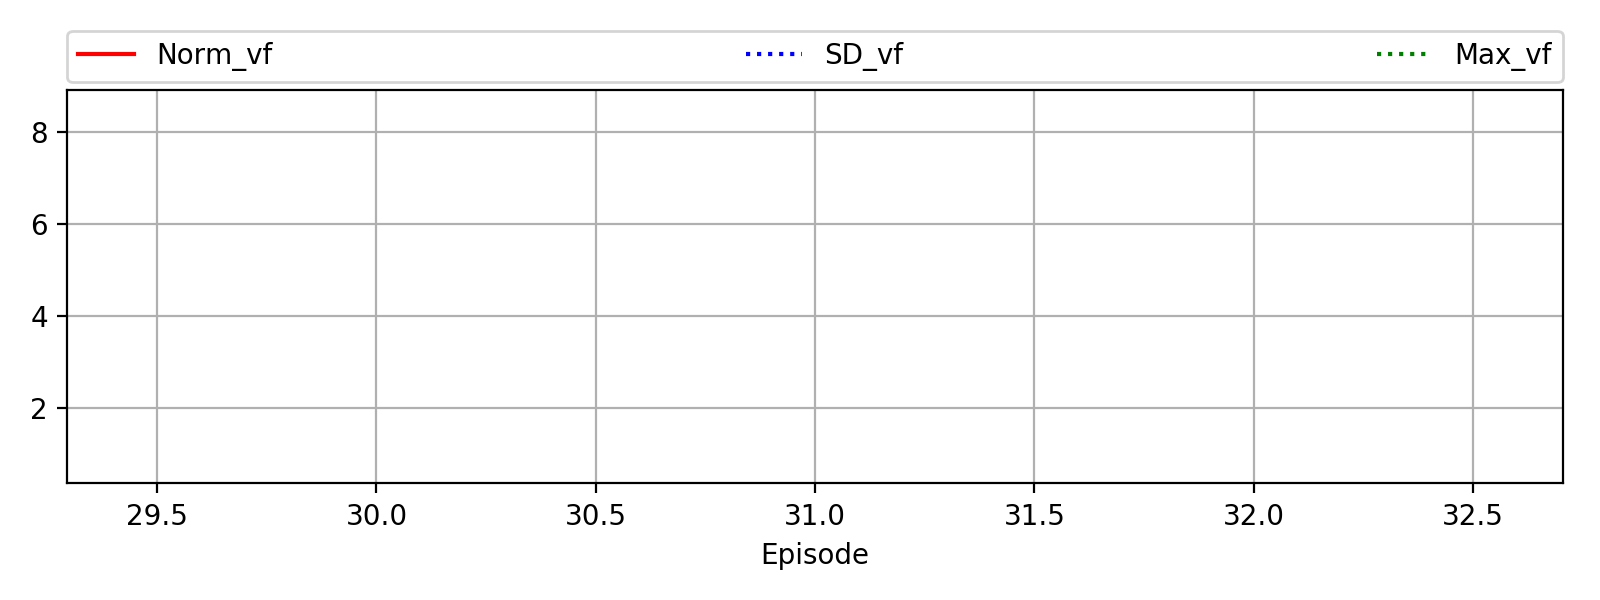

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    20
	Rollout Limit:      1
Agent
*** SCALER WARMUP COMPLETE *** 
ValFun  Gradients: u/sd/Max/C Max/Max u/Max sd :   0.1446   0.1342   0.5721   0.5721   0.1446   0.1342
Update Cnt = 0    ET =     26.6   Stats:  Mean, Std, Min, Max
r_f      |    -0.0    -0.0    -0.0 |     0.1     0

In [9]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model_noise import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch


from policy_drdv import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15., 
                            sensor_pos_bias_range=(-0.10,0.10), sensor_vel_bias_range=(-0.10,0.10))
lander_model.get_state_agent = lander_model.get_state_agent1

obs_dim = 6
act_dim = 3
recurrent_steps = 20

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(3)

# Test Policy 

In [11]:
policy.test_mode=True

env.test_policy_batch(agent,5000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10295.72 |1135.34 |2000.00 |15000.00 |    22
glideslope | 2.590 | 4.957 | 0.077 |172.850 |    12
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.397 |   0.247 |   0.003 |   0.923
norm_rf  |     0.0 |     0.0 |     0.0 |     0.0
position |    -0.0    -0.0    -0.0 |     0.0     0.0     0.0 |    -0.0    -0.0    -0.0 |     0.0     0.0    -0.0
velocity |  -0.027  -0.014  -0.327 |   0.162   0.163   0.241 |  -0.645  -0.584  -0.898 |   0.678   0.456   0.026
fuel     |258.66 | 17.50 |225.45 |318.17
glideslope | 10.10 | 24.47 |  0.08 |172.85
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10337.20 |1167.38 |2000.00 |15000.00 |    22
glideslope | 2.615 | 4.415 | 0.077 |172.850 |    12
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.477 |   1.023 |   0.003 |  14.423
norm_rf  |     0.0 |     0.5 |     0.0 |     7.1
position |    

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |10289.38 |1205.19 |2000.00 |15000.00 |   256
glideslope | 2.760 | 6.909 | 0.031 |879.297 |  1209
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.457 |   0.781 |   0.000 |  18.207
norm_rf  |     0.1 |     2.0 |     0.0 |    75.7
position |     0.0     0.0    -0.0 |     1.9     0.8     0.0 |    -3.3    -2.9    -0.3 |    69.2    30.7    -0.0
velocity |  -0.064  -0.006  -0.355 |   0.506   0.353   0.554 | -16.471  -7.666 -13.094 |   4.324   3.339   0.046
fuel     |258.33 | 18.52 |204.50 |318.17
glideslope |  8.40 | 21.97 |  0.04 |332.90
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |10288.64 |1204.72 |2000.00 |15000.00 |   256
glideslope | 2.761 | 6.824 | 0.031 |879.297 |  1209
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.454 |   0.758 |   0.000 |  18.207
norm_rf  |     0.1 |     2.0 |     0.0 |    75.7
position |  

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |10306.80 |1220.40 |2000.00 |15000.00 |   256
glideslope | 2.791 |10.048 | 0.018 |5858.355 |  2416
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.485 |   0.993 |   0.000 |  20.135
norm_rf  |     0.1 |     2.1 |     0.0 |    75.7
position |     0.1    -0.0    -0.0 |     1.9     0.9     0.0 |    -3.3   -27.7    -0.4 |    69.2    30.7    -0.0
velocity |  -0.072   0.007  -0.376 |   0.545   0.414   0.779 | -16.471  -7.666 -17.117 |   4.411   9.640   0.046
fuel     |257.86 | 18.62 |193.46 |326.89
glideslope |  8.63 | 23.50 |  0.02 |446.03
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |10301.87 |1223.56 |2000.00 |15000.00 |   256
glideslope | 2.789 | 9.932 | 0.018 |5858.355 |  2416
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.482 |   0.978 |   0.000 |  20.135
norm_rf  |     0.1 |     2.1 |     0.0 |    75.7
position |

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |10298.99 |1229.34 |2000.00 |15000.00 |   256
glideslope | 2.787 | 9.092 | 0.018 |5858.355 |  2416
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.494 |   1.018 |   0.000 |  20.135
norm_rf  |     0.1 |     1.9 |     0.0 |    75.7
position |     0.0    -0.0    -0.0 |     1.7     1.0     0.0 |    -3.3   -27.7    -0.5 |    69.2    31.9    -0.0
velocity |  -0.070   0.004  -0.379 |   0.522   0.460   0.805 | -16.471 -10.602 -17.117 |   4.411   9.977   0.074
fuel     |257.65 | 18.76 |193.46 |326.89
glideslope |  8.51 | 22.90 |  0.02 |446.03
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |10299.32 |1227.52 |2000.00 |15000.00 |   256
glideslope | 2.777 | 8.997 | 0.018 |5858.355 |  2416
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.492 |   1.007 |   0.000 |  20.135
norm_rf  |     0.1 |     1.9 |     0.0 |    75.7
position |